In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


from configurations import load_data, make_data_paths, save_fig, create_fig, set_font_sizes, apply_general_styles, make_params_dict
from configurations.plot_config import FONTSIZES
# from sam.small_models import InductionHeadAttention, warm_initialization, interpolation_initialization
from sam.small_models import noisy_initialization
from sam.dataset import get_sample_permut, get_dataloader
from sam.evaluation import evaluate_model

from sam.small_models import InductionHeadAttention
from sam.dataset import get_sample_permut

apply_general_styles()

In [195]:
# print parameters of model

def perturb_parameters(model, perturbations , epsilon, device, beta=1.0):
    # Make copy of model 
    new_model = Lin_Sfm_Attention(vocab_size=model.vocab_size, seq_len=model.seq_len,attn=model.attn).to(device)
    new_model.load_state_dict(model.state_dict())

    with torch.no_grad():
        for name, param in new_model.named_parameters():
            # Skip if betas , embedding or positions
            if 'beta' in name or 'embedding' in name or 'position' in name:
                continue
            name = name.split('.')[0]
            if name in perturbations:
                param += epsilon * perturbations[name]
    
    # Set all betas to beta
    with torch.no_grad():
        for name, param in new_model.named_parameters():
            if 'beta' in name:
                param.fill_(beta)
    
    return new_model



# Restructured Runs

In [274]:
# Fix Parameters
vocab_size = 64 # Vocabulary size
seq_len = 64  # Sequence length
batch_size = 32 # Batch size
dataset_size = 5000 # Dataset size
train_fraction = 0.8 # Fraction of data used for training
beta_1 = 1.0  # Induction head beta_1 parameter
beta_2 = 1.0  # Induction head beta_2 parameter
beta_out = 1.0  # Induction head beta_out parameter

# Variable Parameters
num_epochs = 200 # Number of training epochs 
lr = 0.1 # Learning rate
cV = 1.1     # Coefficient for WV1  
alpha = 0.5 # Coefficient for interpolation 
opt = 'SAM' # Optimizer choice  =  'SGD' or 'adam' or 'SAM'
p_error = 0.0 # Probability of introducing noise in the target for the induction task
rho = 0.0 # Rho parameter for SAM optimizer
attn = 'linear' # Type of attention: linear or softmax
loss = 'CE'
experiment_name = 'opt_lin_CE'


# List of variables to loop over
variable = [0.0,0.1,0.2][:]
variable_name = r'$\rho$'

# Load Data
fix_names = ['vocab_size','seq_len','lr','num_epochs']

results = {}
for var in variable:
    rho = var
    var_names = ['alpha','cV','opt','rho','p_error','attn','loss']
    params = make_params_dict(fix_names, var_names)
    data = load_data('summary',experiment_name,params,show=False)
    results[var] = data
    print(f"Alpha: {alpha}, Data: {data.keys()}")


Alpha: 0.5, Data: dict_keys(['model_step', 'global_step', 'train_loss', 'val_loss', 'val_accuracy', 'target_mass', 'epc_step', 'epc_model_step'])
Alpha: 0.5, Data: dict_keys(['model_step', 'global_step', 'train_loss', 'val_loss', 'val_accuracy', 'target_mass', 'epc_step', 'epc_model_step'])
Alpha: 0.5, Data: dict_keys(['model_step', 'global_step', 'train_loss', 'val_loss', 'val_accuracy', 'target_mass', 'epc_step', 'epc_model_step'])


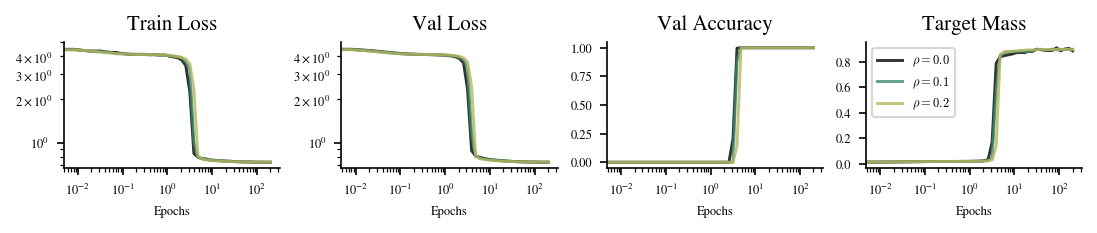

In [ ]:
# Settings
cmap = 'gist_earth'
labels = ['train_loss','val_loss','val_accuracy','target_mass']
ncols = len(labels)
colors = plt.get_cmap(cmap)(np.linspace(0, 0.7, len(variable)))
setting = dict(lw=1.4,marker='',markersize=2,alpha=0.8)
set_font_sizes(conf='tight')

# Plot
fig , axes = create_fig(ncols=ncols, size='double',h=0.2)


for i , ax in enumerate(axes):
    ax.set_prop_cycle(color=colors)
    ax.set_xlabel('Epochs',fontsize=FONTSIZES['xs'])
    ax.set_title(labels[i].replace('_',' ').title())
    for var in variable:
        data = results[var]
        setting['label']=variable_name+rf'$={var}$' if i == ncols-1 else None
        ax.plot(data['epc_step'],  data[labels[i]], **setting)

ax.legend()
ax.set_xscale('log')
# ax.set_xlim(left=data['epc_step'][1])

axes[0].set_yscale('log')
axes[1].set_yscale('log')



names_plot = ['vocab_size','seq_len','lr','num_epochs','alpha','cV','opt','p_error','attn','loss']
params = make_params_dict(names_plot)
save_fig(fig, 'learning',params=params,date=True)

# Model Performance

In [80]:
from sam.small_models import Lin_Sfm_Attention
from sam.evaluation import evaluate_model_lin_sfm
import torch.nn as nn

In [272]:



var = 0.1
rho = var
fix_names = ['vocab_size','seq_len','lr','num_epochs']
var_names = ['alpha','cV','opt','rho','p_error','attn','loss']
params = make_params_dict(fix_names, var_names)

data = results[var]
step = data['model_step'][-1]
print(f"Loading model for var={var} at step {step}")
file_path , _, _ = make_data_paths(f'model_{step}', experiment_name, params=params,ext='pt',base_dir='../data') 
# file_path , _, _ = make_data_paths(f'model_{step}', experiment_name, params=params,ext='pt',base_dir='../data')     
model_state = torch.load(file_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Lin_Sfm_Attention(vocab_size,seq_len,attn=attn).to(device)
model.load_state_dict(model_state)

train_loader = load_data('train_loader',experiment_name,params=params,show=True)
val_loader = load_data('val_loader',experiment_name,params=params,show=False)


if loss == 'CE':
    print("Using Cross Entropy Loss")
    CE_loss = nn.CrossEntropyLoss(label_smoothing=0.0)
    loss_fn = CE_loss
elif loss == 'MSE':
    print("Using Mean Squared Error Loss")
    MSE_loss = nn.MSELoss()
    loss_fn = MSE_loss

# Evaluate the model
val_loss , val_accuracy , target_mass =  evaluate_model_lin_sfm(model, train_loader, device, loss_fn,loss_type=loss)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Target Mass: {target_mass}")



Loading model for var=0.1 at step 24999
File train_loader_alpha0.5_attnlinear_cV1.1_lossCE_optSAM_p_error0_rho0.1.pkl loaded with pickle.load from /u/c/cerazova/SAM/data/opt_lin_CE/lr0.1_num_epochs200_seq_len64_vocab_size64
Using Cross Entropy Loss
Validation Loss: 0.10264961546659469, Validation Accuracy: 1.0, Target Mass: 0.9024614491462708


/tmp/ipykernel_3245959/2589220914.py:45: MatplotlibDeprecationWarning: Since Matplotlib 3.10 indicate_inset_[zoom] returns a single InsetIndicator artist with a rectangle property and a connectors property.  From 3.12 it will no longer be possible to unpack the return value into two elements.
  box, c1 = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)


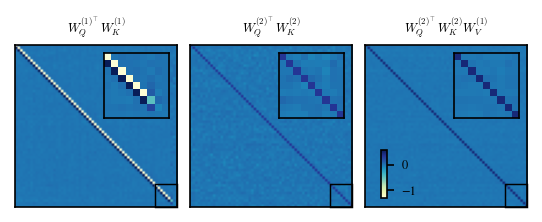

In [ ]:
set_font_sizes(conf='tight')
cmap = 'YlGnBu'
titles = [r'$W_Q^{(1)^\top} W_K^{(1)}$',r'$W_Q^{(2)^\top} W_K^{(2)}$',r'$W_Q^{(2)^\top} W_K^{(2)} W_V^{(1)}$']
ncols = 3
nrows = 1
V = vocab_size
x = np.arange(V)
# Create figure
fig , axes = create_fig(ncols=ncols,nrows=nrows,size='single',h=0.46,sharex=False)

with torch.no_grad():
    WQ1 = model.WQ1.weight.cpu().numpy()
    WK1 = model.WK1.weight.cpu().numpy()
    WQ2 = model.WQ2.weight.cpu().numpy()
    WK2 = model.WK2.weight.cpu().numpy()
    WV1 = model.WV1.weight.cpu().numpy()
matrices = [WQ1.T@WK1, WQ2.T@WK2, WQ2.T@WK2@WV1]
mx = -1e9
mn = 1e9
for M in matrices:
    mx = max(mx, M.max()) * 0.7
    mn = min(mn, M.min()) * 1.0

for j , lb in enumerate(titles):
    ax = axes[j]
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.spines[['bottom','left','top','right']].set_visible(True)
    ax.set_title(titles[j],fontsize=FONTSIZES['xs']) 
    M = matrices[j]
    # mx = M.max()
    # ax.pcolormesh(x,x[::-1],M,cmap=cmap,vmax=mx*0.3,shading=None)
    im = ax.imshow(M,cmap=cmap,vmax=mx,vmin=mn)
    # Insert axis to show closer look at the top-left corner
    if True:
        axins = ax.inset_axes([0.55, 0.55, 0.4, 0.4])  # [x0, y0, width, height]
        axins.spines[['bottom','left','top','right']].set_visible(True)
        # axins.pcolormesh(x,x[::-1],M,cmap=cmap,vmax=mx*0.3)
        axins.imshow(M,cmap=cmap,vmax=mx,vmin=mn)
        # axins.plot([0,V],[0,V],ls='--',c='red',lw=0.5)
        axins.set_xlim(V-9.5,V-0.5)
        axins.set_ylim(V-0.5,V-9.5)
        axins.set_xticks([])
        axins.set_yticks([])
        # ax.indicate_inset_zoom(axins, edgecolor='black', lw=0.5)
        box, c1 = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)
        c1[0].set_visible(False)
        c1[1].set_visible(False)
        c1[2].set_visible(False)
        c1[3].set_visible(False)
        # ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)
        plt.setp([c1[:]], linestyle=":", lw=0.7)

cbar_ax = fig.add_axes([0.71, 0.2, 0.01, 0.2])  # [left, bottom, width, height]
cbar = fig.colorbar(axes[0].images[0], cax=cbar_ax)


names_plot = ['vocab_size','seq_len','lr','num_epochs','alpha','cV','opt','rho','p_error','attn','loss']
params = make_params_dict(names_plot)
# save_fig(fig, 'matrices_end',params=params,date=True)


# Perturbate Model

In [260]:
# Create random perturbation of parameters
names = ['WQ1', 'WK1', 'WV1', 'WQ2', 'WK2']
shapes = [(seq_len, seq_len), (seq_len, seq_len), (vocab_size, vocab_size), (vocab_size, vocab_size), (vocab_size, vocab_size)]
perturbations = {name: torch.randn(shape).to(device) for name, shape in zip(names, shapes)}

# Normalize each row
for name in names:
    perturbations[name] = perturbations[name] / torch.norm(perturbations[name], dim=1, keepdim=True)


In [261]:
eps = np.linspace(-1, 1, 35)

results_perturb = []
for epsilon in eps:
    # print(f"Perturbing with epsilon: {epsilon:.2f}")
    new_model = perturb_parameters(model, perturbations, epsilon=epsilon,device=device,beta=1.0)
    results_perturb.append(evaluate_model_lin_sfm(new_model, val_loader, device, loss_fn,loss_type=loss))
    # print(f"New Validation Loss: {new_val_loss:.4f}, New Validation Accuracy: {new_val_accuracy:.4f}, New Target Mass: {new_target_mass:.4f}")

results_perturb = np.array(results_perturb)
print(results_perturb.shape)


(35, 3)


Figure saved on /u/c/cerazova/SAM/plots/2026-02 as perturbation_alpha0.5_attnsoftmax_cV1.1_lr0.3_num_epochs200_optSAM_p_error0_rho0.2_seq_len64_vocab_size64.png


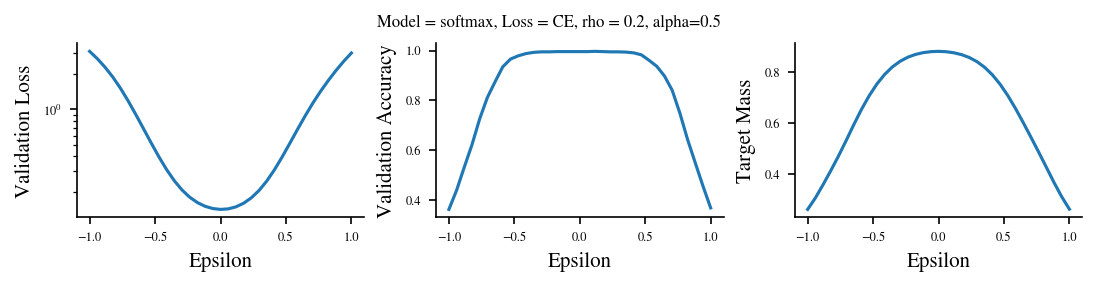

In [262]:
fig , axes = create_fig(ncols=3,size='double',h=0.25)

for i , ax in enumerate(axes):
    ax.plot(eps, results_perturb[:,i])
    ax.set_xlabel('Epsilon')
    if i == 0:
        ax.set_ylabel('Validation Loss')
    elif i == 1:
        ax.set_ylabel('Validation Accuracy')
    else:
        ax.set_ylabel('Target Mass')

axes[0].set_yscale('log')

fig.suptitle(f'Model = {attn}, Loss = {loss}, rho = {rho}, alpha={alpha}', fontsize=FONTSIZES['s'])

names_plot = ['vocab_size','seq_len','lr','num_epochs','alpha','cV','opt','rho','p_error','attn']
params = make_params_dict(names_plot)
save_fig(fig, 'perturbation',params=params,date=True)


In [9]:
n1, n2 = 4, 7
ex_linear = torch.nn.Linear(n1,n2,bias=False)

x = torch.randn(n1)
y = ex_linear(x)
print(x.shape, y.shape)
W = ex_linear.weight.data
print(W.shape)

torch.Size([4]) torch.Size([7])
torch.Size([7, 4])


# Other

In [5]:
# Parameters
vocab_size = 64 # Vocabulary size
seq_len = 64  # Sequence length
lr = 0.05 # Learning rate
alpha = 1.0
cV = 1.1    
opt = 'SGD'
rho = 0.0
gamma = 0.0 # Weight decay for sgd
p_error = 0.0 # Probability of random token replacement in the input sequence (data

states = ['init','fin']

fix_names = ['vocab_size','seq_len','lr']
var_names = ['alpha','cV','opt','rho','gamma','p_error'][:2]
params = make_params_dict(fix_names, var_names)

model = InductionHeadAttention(vocab_size=vocab_size, seq_len=seq_len)
models = {}
for state in states:
    file_path , _, _ = make_data_paths(f'model_{state}', experiment_name= 'small_induction_head', params=params,ext='pt',base_dir='../data')     
    models[state] = torch.load(file_path)

for key in models[state].keys():
    print(key, models[state][key].shape)

for state in states:
    text = ''
    for key in models[state].keys():
        if 'beta' in key:
            text += f'{key}: {models[state][key].cpu().numpy()}'
    print(f'{state}:\n{text}')

beta_1 torch.Size([])
beta_2 torch.Size([])
beta_out torch.Size([])
embedding.weight torch.Size([64, 64])
positions.weight torch.Size([64, 64])
WQ1.weight torch.Size([64, 64])
WK1.weight torch.Size([64, 64])
WV1.weight torch.Size([64, 64])
WQ2.weight torch.Size([64, 64])
WK2.weight torch.Size([64, 64])
init:
beta_1: 1.0beta_2: 1.0beta_out: 1.0
fin:
beta_1: 1.0beta_2: 1.0beta_out: 1.0


/tmp/ipykernel_3218350/3013794287.py:46: MatplotlibDeprecationWarning: Since Matplotlib 3.10 indicate_inset_[zoom] returns a single InsetIndicator artist with a rectangle property and a connectors property.  From 3.12 it will no longer be possible to unpack the return value into two elements.
  box, c1 = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)


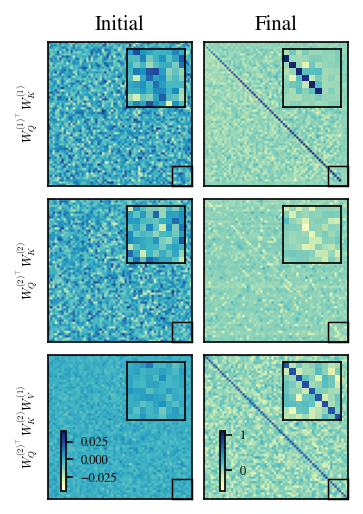

In [6]:
set_font_sizes(conf='tight')
cmap = 'YlGnBu'
titles = [r'$W_Q^{(1)^\top} W_K^{(1)}$',r'$W_Q^{(2)^\top} W_K^{(2)}$',r'$W_Q^{(2)^\top} W_K^{(2)} W_V^{(1)}$']
ncols = 2
nrows = 3
V = vocab_size
x = np.arange(V)
# Create figure
fig , axes = create_fig(ncols=ncols,nrows=nrows,size='double',w=0.32,h=0.46,sharex=False)

for i , state in enumerate(states):
    WQ1 = models[state]['WQ1.weight'].cpu().numpy()
    WK1 = models[state]['WK1.weight'].cpu().numpy()
    WQ2 = models[state]['WQ2.weight'].cpu().numpy()
    WK2 = models[state]['WK2.weight'].cpu().numpy()
    WV1 = models[state]['WV1.weight'].cpu().numpy()
    matrices = [WQ1.T@WK1, WQ2.T@WK2, WQ2.T@WK2@WV1]
    mx = -1e9
    mn = 1e9
    for M in matrices:
        mx = max(mx, M.max())
        mn = min(mn, M.min())

    for j , lb in enumerate(titles):
        ax = axes[j,i]
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.spines[['bottom','left','top','right']].set_visible(True)
        if j == 0: ax.set_title([r'Initial', r'Final'][i])
        if i == 0: ax.set_ylabel(titles[j],fontsize=FONTSIZES['xs']) 
        M = matrices[j]
        # mx = M.max()
        # ax.pcolormesh(x,x[::-1],M,cmap=cmap,vmax=mx*0.3,shading=None)
        im = ax.imshow(M,cmap=cmap,vmax=mx,vmin=mn)
        # Insert axis to show closer look at the top-left corner
        if True:
            axins = ax.inset_axes([0.55, 0.55, 0.4, 0.4])  # [x0, y0, width, height]
            axins.spines[['bottom','left','top','right']].set_visible(True)
            # axins.pcolormesh(x,x[::-1],M,cmap=cmap,vmax=mx*0.3)
            axins.imshow(M,cmap=cmap,vmax=mx,vmin=mn)
            # axins.plot([0,V],[0,V],ls='--',c='red',lw=0.5)
            axins.set_xlim(V-9.5,V-0.5)
            axins.set_ylim(V-0.5,V-9.5)
            axins.set_xticks([])
            axins.set_yticks([])
            # ax.indicate_inset_zoom(axins, edgecolor='black', lw=0.5)
            box, c1 = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)
            c1[0].set_visible(False)
            c1[1].set_visible(False)
            c1[2].set_visible(False)
            c1[3].set_visible(False)
            # ax.indicate_inset_zoom(axins, edgecolor="black", alpha=1,lw=0.7)
            plt.setp([c1[:]], linestyle=":", lw=0.7)
            

# Add a floating colorbar on the center of the figure
cbar_ax = fig.add_axes([0.15, 0.03, 0.015, 0.12])  # [left, bottom, width, height]
cbar = fig.colorbar(axes[0,0].images[0], cax=cbar_ax)

cbar_ax = fig.add_axes([0.61, 0.03, 0.015, 0.12])  # [left, bottom, width, height]
cbar = fig.colorbar(axes[0,1].images[0], cax=cbar_ax)
# Set ticks color to white
# cbar.ax.tick_params(labelcolor='white')

# cbar.set_label('Value', rotation=270, labelpad=15)
# names = [*fix_names, '']
params = make_params_dict([*fix_names,'alpha'])
# params = make_params_dict
# params
# save_fig(fig, 'init_fin_matrices',params=params,date=True)
